In [1]:
#!pip install -Uq diffusers ftfy accelerate

In [2]:
#!pip install -Uq git+https://github.com/huggingface/transformers

In [3]:
import torch
import requests
from PIL import Image
from io import BytesIO
from matplotlib import pyplot as plt

In [4]:
# pipelines
from diffusers import (
    StableDiffusionPipeline, 
    StableDiffusionImg2ImgPipeline,
    StableDiffusionInpaintPipeline, 
    StableDiffusionDepth2ImgPipeline
    )       

def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content)).convert("RGB")

# Download images for inpainting example
img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

init_image = download_image(img_url).resize((512, 512))
mask_image = download_image(mask_url).resize((512, 512))

In [5]:
# Set device
device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

### Generating Images from Text

위에서 diffusers에 포함된 여러 StableDiffusion 파이프라인들을 활용해서 어떤 것 들이 가능한지 확인해보자. StableDiffusion 모델은 현재까지 여러 버전이 출시되었으며, 이번 예시에서는 2.1 버전을 활용할 것이다. 이전 모델을 사용하려면 모델 ID를 적절하게 바꾸면 되는데, 예를 들어, "CompVis/stable-diffusion-v1-4"버전이 유명하고, dreambooth concepts library를 참조하면 되겠다.

In [6]:
# Load the pipeline
model_id = "stabilityai/stable-diffusion-2-1-base"
pipe = StableDiffusionPipeline.from_pretrained(model_id).to(device)

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

/root/miniconda3/envs/diffusion/lib/python3.8/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


GPU 메모리가 부족하면, 아래와 같은 방법을 참조하기 바란다:

* FP16 버전을 로드하는 방법이 있다. 그러나, 이 버전은 항상 모든 시스템에서 동작하지는 않으며, 텐서 역시 torch.float16으로 변환한 다음 실험해야하는 불편한 점이 있다:

    pipe = StableDiffusionPipeline.from_pretrained(model_id, revision="fp16", torch_dtype=torch.float16).to(device)

* attention slicing을 사용한 제어 방법이 있다:

    pipe.enable_attention_slicing()

* 당연하지만, 생성하고 싶은 이미지 사이즈를 줄이는 것이 가장 확실한 해결책인 듯 하다.

파이프라인이 로딩 되었다면, 이제 프롬프트로부터 아래의 코드와 같이 이미지를 생성할 수 있다.

  0%|          | 0/35 [00:00<?, ?it/s]

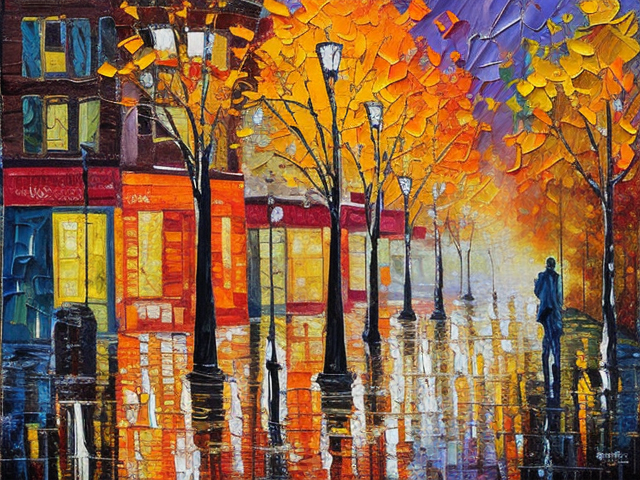

In [7]:
# Set up a generator for reproducibility
generator = torch.Generator(device=device).manual_seed(42)

# Run the pipeline, showing some of the available arguments
pipe_output = pipe(
    prompt="Palette knife painting of an autumn cityscape", # What to generate
    negative_prompt="Oversaturated, blurry, low quality", # What NOT to generate
    height=480, width=640,     # Specify the image size
    guidance_scale=8,          # How strongly to follow the prompt
    num_inference_steps=35,    # How many steps to take
    generator=generator        # Fixed random seed
)

# View the resulting image:
pipe_output.images[0]

위의 예시 코드로 프롬프트를 비롯한 다른 인자값을 바꿔가며 결과 이미지가 어떻게 달라지는지 확인해보기 바란다. 그리고, torch.Generator에 관해, 다른 random seed를 사용하거나 generator 인자를 아예 제거하면 매번 다른 결과가 얻어지게 될 것이다.

**주요 인자값**:

* 너비와 높이(width, height)는 생성하려는 이미지의 크기를 지정하는 값이다. 중요한 점은, 이 값들이 8의 배수일 때에 한해 VAE가 동작한다는 사실이다(곧 아래에서 설명).
* num_inference_steps는 생성된 이미지의 품질에 직접적인 영향을 미친다. default로 50이 주어지는데, 경우에 따라 20 스텝까지도 좋은 결과를 내기도 한다.
* negative_prompt는 classifier-free guidance 프로세스에서 사용되며, 추가적인 제어를 담당하기 때문에 유용할 수 있다. 무시해도 좋으나, 이 부분에 생성을 원하지 않는 정보를 남겨두면 더 나은 이미지를 생성한다는 것이 경험적으로 알려져 있다.
* guidance_scale은 classifier-free guidance(CFG)를 얼마나 강하게 줄지를 결정한다. 높은 스케일일수록 프롬프트에 더욱 충실한 이미지를 생성하지만, 이 값이 너무 높으면 결과물의 품질이 좋지 않을 수 있다.

프롬프트에 관한 아이디어가 필요하면, Stable Diffusion Prompt Book도 좋은 참고 자료가 될 것이다.

guidance scale의 조정에 따른 결과는 아래 셀에서 확인할 수 있다:

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

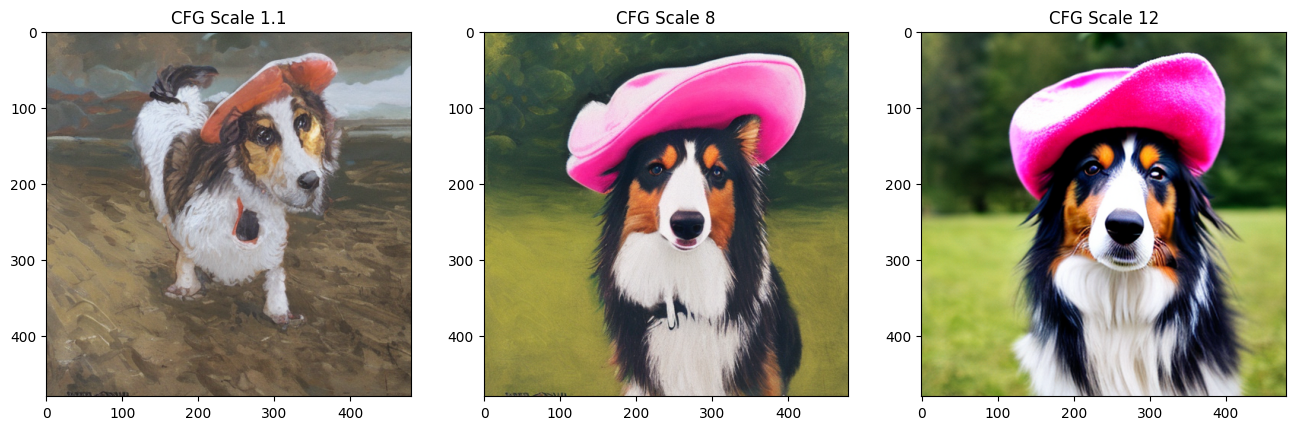

In [8]:
# comparing guidance scales:
cfg_scales = [1.1, 8, 12]
prompt = "A collie with a pink hat"
fig, axs = plt.subplots(1, len(cfg_scales), figsize=(16, 5))
for i, ax in enumerate(axs):
    im = pipe(prompt, height=480, width=480,
    guidance_scale=cfg_scales[i], num_inference_steps=35,
    generator=torch.Generator(device=device).manual_seed(42)).images[0]
    ax.imshow(im); ax.set_title(f'CFG Scale {cfg_scales[i]}');

위 셀에서 스케일과 프롬프트를 바꿔가면서 실험해보기 바란다. 결과물에 관한 해석은 주관적이겠지만, 8에서 12까지가 가장 좋은 결과를 내는 것을 알 수 있다.

### Pipeline Conponents

Diffusers를 직접 찾아보면, 우리가 사용중인 StableDiffusionPipeline 외에도 다양한 파이프라인들이 존재하고, DDPMPipeline에 비하면 훨씬 복잡하다. DDPMPipeline에서도 동일하게 존재했던 unet과 scheduler 외에도 다양한 component들이 존재한다.

In [9]:
print(list(pipe.components.keys())) # List components

['vae', 'text_encoder', 'tokenizer', 'unet', 'scheduler', 'safety_checker', 'feature_extractor']


이 파이프라인이 어떻게 동작하는지 이해하기 위해서, 각 component가 어떤 역할을 하는지 독립적으로 살펴봐야 할 것이다.

#### The VAE

![vae](./img/vae.png)

VAE(variational autoencoder, 변분적 자기부호화기)는 input 이미지를 적당한 형태의 표현(representation, latent)으로 압축(encoding)했다가 원래의 input 이미지와 최대한 가까운 이미지로 복원(decoding)하는 모델이다. Stable diffusion으로 이미지를 생성한다는 것은, 먼저 VAE의 latent 공간에서 diffusion process를 적용해서 latent를 생성한 다음 그것을 복원하는 것을 의미한다. 

아래의 코드는 input 이미지를 받아서 latent를 압축한 다음 VAE를 사용해 다시 복원하는 과정을 보여준다;

In [10]:
# Create some fake data (a random image, range (-1, 1))
images = torch.rand(1, 3, 512, 512).to(device) * 2 - 1 
print("Input images shape:", images.shape)

# Encode to latent space
with torch.no_grad():
    latents = 0.18215 * pipe.vae.encode(images).latent_dist.mean
print("Encoded latents shape:", latents.shape)

# Decode again
with torch.no_grad():
    decoded_images = pipe.vae.decode(latents / 0.18215).sample
print("Decoded images shape:", decoded_images.shape)

Input images shape: torch.Size([1, 3, 512, 512])
Encoded latents shape: torch.Size([1, 4, 64, 64])
Decoded images shape: torch.Size([1, 3, 512, 512])


위 결과로부터, 인코더를 통해 512x512 3채널 이미지가 64x64 크기의 4채널 latent representation으로 압축된 것을 확인할 수 있다. 앞서 말한 지정된 너비와 높이가 8의 배수여야 하는 이유는, 이 부분이 8x 압축률로 구현되었기 때문이다.

4x64x64 사이즈의 latent들이 512px 이미지를 다루는 것 보다 리소스 사용 측면에서 더 효율적이기 때문에, diffusion 모델도 더 빠르게 동작할 수 있다. VAE의 복원 프로세스는 일반적으로 완벽하지 않지만 품질 측면에서 크게 문제가 되지 않는다.

추가로, 위 예시는 Stable diffusion 학습과 관련있는 0.18215의 scaling factor가 포함되어 있다.

#### The Tokenizer and Text Encoder

![tokenizer](./img/tokenizer.png)

텍스트 인코더의 궁극적인 목표는 입력 prompt를 UNet에 입력할 수 있도록 numerical한 표현으로 바꿔주는 것이다. 텍스트 prompt는 먼저 tokenizer pipeline을 통해 일련의 토큰으로 변환된다. 텍스트 인코더에는 약 50k 토큰에 해당하는 어휘 정보가 있고, 이 어휘에 없는 단어는 더욱 작은 하위 단어로 쪼개진다. 그런 다음, 토큰은 원래의 CLIP용 텍스트 인코더로 학습된 트랜스포머 모델 자체에 입력된다. 이 사전 학습 트랜스포머 모델이 diffusion 태스크에도 유용한 풍부한 텍스트 표현을 배웠다는 점이 희망적이다.

아래는 prompt를 인코딩하는 프로세스를 테스트하는 과정으로, 우선, 수동으로 텍스트를 token화 하고 텍스트 인코더에 입력한 다음 파이프라인의 "_encode_prompt" 메서드를 사용해서 최대 길이 77개 token으로 채우고 있다. 

In [11]:
# Tokenizing and encoding an example prompt manualy:

# Tokenize
input_ids = pipe.tokenizer(["A painting of a flooble"])['input_ids']
print("Input ID -> decoded token")
for input_id in input_ids[0]:
    print(f"{input_id} -> {pipe.tokenizer.decode(input_id)}")

# Feed through CLIP text encoder
input_ids = torch.tensor(input_ids).to(device)
with torch.no_grad():
    text_embeddings = pipe.text_encoder(input_ids)['last_hidden_state']
print("Text embeddings shape:", text_embeddings.shape)

Input ID -> decoded token
49406 -> <|startoftext|>
320 -> a
3086 -> painting
539 -> of
320 -> a
4062 -> floo
1059 -> ble
49407 -> <|endoftext|>
Text embeddings shape: torch.Size([1, 8, 1024])


In [12]:
# Get the final text embeddings using the pipeline's _encode_prompt function:
text_embeddings = pipe._encode_prompt("A painting of a flooble", device, 1, False, '')
text_embeddings.shape

torch.Size([1, 77, 1024])

이와 같은 텍스트 임베딩(=텍스트 인코더 모델에서 마지막 트랜스포머 블록의 hidden state)은 다음 셀에서 볼 수 있는 전달 방식을 통해 UNet으로 입력된다.

### The UNet

![unet](./img/unet.png)

UNet은 노이즈를 입력으로 받아 노이즈를 예측하는 역할을 한다. 여기서 입력은 이미지가 아니라 이미지의 latent 표현이다. 그리고 timestep conditioning 외에도, 이 UNet에서 prompt의 텍스트 임베딩을 추가 입력으로 받는다. 아래는 일부 더미 데이터에 대한 예측이다.

In [13]:
# Dummy inputs:
timestep = pipe.scheduler.timesteps[0]
latents = torch.randn(1, 4, 64, 64).to(device)
text_embeddings = torch.randn(1, 77, 1024).to(device)

# Model prediction:
with torch.no_grad():
    unet_output = pipe.unet(latents, timestep, text_embeddings).sample
print('UNet output shape:', unet_output.shape) # Same shape as the input latents

UNet output shape: torch.Size([1, 4, 64, 64])


### The Scheduler

스케줄러는 노이즈 일정을 저장하고 모델의 예측을 기반으로 노이즈 샘플 업데이트를 관리해준다. 기본 스케줄러는 PNDMScheduler이지만 동일한 구성으로 초기화되는 다른 스케줄러(예: LMSDiscreteScheduler)를 사용할 수 있다.

시간 경과에 따른 노이즈(알파 기반)를 보기 위해 노이즈 레벨을 플롯할 수 있다.

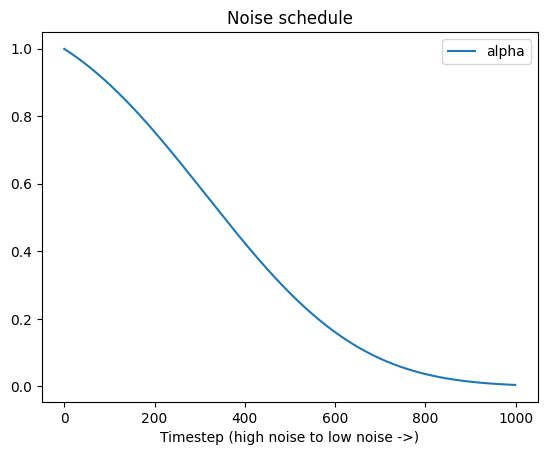

In [14]:
plt.plot(pipe.scheduler.alphas_cumprod, label=r'alpha')
plt.xlabel('Timestep (high noise to low noise ->)');
plt.title('Noise schedule');plt.legend();

다른 스케줄러를 사용해 보고 싶다면, 아래와 같으 교체가 가능하다.

Scheduler config: LMSDiscreteScheduler {
  "_class_name": "LMSDiscreteScheduler",
  "_diffusers_version": "0.13.1",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "trained_betas": null
}



  0%|          | 0/50 [00:00<?, ?it/s]

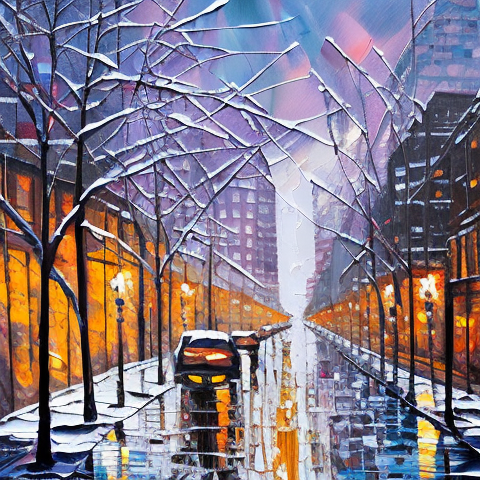

In [15]:
from diffusers import LMSDiscreteScheduler #!pip install scipy

# Replace the scheduler
pipe.scheduler = LMSDiscreteScheduler.from_config(pipe.scheduler.config)

# Print the config
print('Scheduler config:', pipe.scheduler)

# Generate an image with this new scheduler
pipe(prompt="Palette knife painting of an winter cityscape", height=480, width=480,
     generator=torch.Generator(device=device).manual_seed(42)).images[0]

### A DIY Sampling Loop

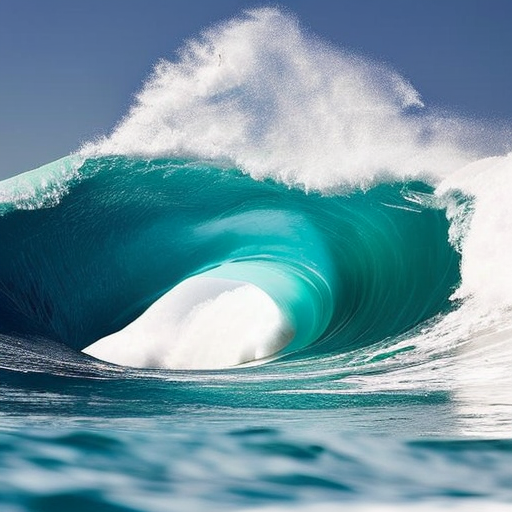

In [16]:
guidance_scale = 8 # param
num_inference_steps=30 # param
prompt = "Beautiful picture of a wave breaking" # param
negative_prompt = "zoomed in, blurry, oversaturated, warped" # param

# Encode the prompt
text_embeddings = pipe._encode_prompt(prompt, device, 1, True, negative_prompt)

# Create our random starting point
latents = torch.randn((1, 4, 64, 64), device=device, generator=generator)
latents *= pipe.scheduler.init_noise_sigma

# Prepare the scheduler
pipe.scheduler.set_timesteps(num_inference_steps, device=device)

# Loop through the sampling timesteps
for i, t in enumerate(pipe.scheduler.timesteps):

    # expand the latents if we are doing classifier free guidance
    latent_model_input = torch.cat([latents] * 2)

    # Apply any scaling required by the scheduler
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual with the unet
    with torch.no_grad():
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

# Decode the resulting latents into an image
with torch.no_grad():
    image = pipe.decode_latents(latents.detach())

# View
pipe.numpy_to_pil(image)[0]

### Additional Pipelines

prompt로부터 이미지를 생성하는 것 이외에 다른 태스크도 가능하다. 여기부터 Stable Diffusion을 응용한 다른 태스크를 보기 위한 몇 가지 색다른 파이프라인에 관해 알아보겠다. 이 중 일부는 새로운 모델을 다운로드해야 한다.

#### Img2Img

지금까지의 예제에서는 임의 latent에서 시작해 전체 디퓨전 샘플링 루프를 적용, 완전히 처음부터 이미지를 생성했다. 그러나 반드시 처음부터 시작할 필요는 없다. Img2Img 파이프라인은 먼저 기존 이미지를 latent의 집합으로 인코딩한 다음 latent 이미지에 약간의 노이즈를 추가하고 이것을 시작으로 사용한다. 추가된 노이즈의 양과 적용된 노이즈 제거 단계의 수는 img2img 프로세스의 '강도'를 결정한다. 소량의 노이즈(낮은 강도)만 추가하면 변화가 거의 없는 반면 최대 노이즈를 추가하고 전체 노이즈 제거 프로세스를 실행하면 전체 구조의 일부 유사성을 제외하고는 입력과 거의 유사하지 않은 이미지가 생성된다.

이 파이프라인에는 특별한 모델이 필요하지 않으므로 모델 ID가 위의 텍스트에서 이미지로의 예와 동일하면 새 파일을 다운로드할 필요가 없다.

In [17]:
# Loading an Img2Img pipeline
model_id = "stabilityai/stable-diffusion-2-1-base"
img2img_pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id).to(device)

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

앞 설정 부분에서 이 데모에 사용할 예제로 init_image를 로드했지만 원하는 경우 자신의 이미지로 바꿀 수 있다. 파이프라인은 아래와 같다.

  0%|          | 0/30 [00:00<?, ?it/s]

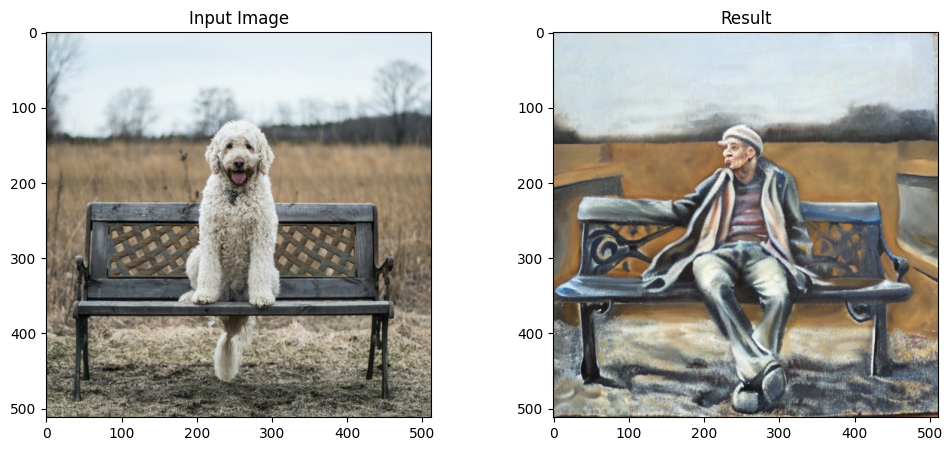

In [18]:
# Apply Img2Img
result_image = img2img_pipe(
    prompt="An oil painting of a man on a bench",
    image = init_image, # The starting image
    strength = 0.6, # 0 for no change, 1.0 for max strength
).images[0]

# View the result
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(init_image);axs[0].set_title('Input Image')
axs[1].imshow(result_image);axs[1].set_title('Result');

이 파이프라인을 새로운 이미지, 프롬프트, 다양한 강도를 사용해서 실행해보기 바란다. 

### In-painting

![inpainting](./img/inpainting.png)

입력 이미지에서 원하는 부분에서만 새로운 이미지를 생성하는 태스크를 'In-painting'이라고 한다. 이전 데모(StableDiffusionInpaintPipelineLegacy를 통해)와 동일한 모델로 수행할 수 있지만, 마스크를 추가적인 condition으로 사용하도록 파인튜닝한 Stable Diffusion을 사용하면 더 나은 결과를 얻을 수 있다. 마스크 이미지는 입력 이미지와 모양이 같아야 하며 대체할 영역은 흰색, 변경하지 않을 영역은 검은색이어야 한다. 다음은 이러한 파이프라인을 로드하고 앞에서 로드된 예제 이미지 및 마스크에 적용하는 방법이다.

In [19]:
# Load the inpainting pipeline (requires a suitable inpainting model)
pipe = StableDiffusionInpaintPipeline.from_pretrained("runwayml/stable-diffusion-inpainting")
pipe = pipe.to(device)

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

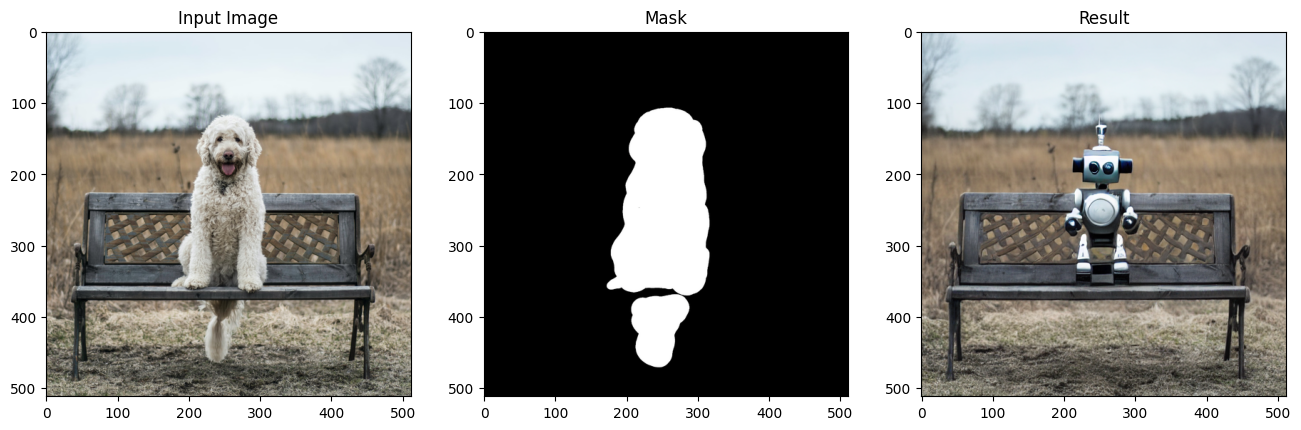

In [20]:
# Inpaint with a prompt for what we want the result to look like
prompt = "A small robot, high resolution, sitting on a park bench"
image = pipe(prompt=prompt, image=init_image, mask_image=mask_image).images[0]

# View the result
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
axs[0].imshow(init_image);axs[0].set_title('Input Image')
axs[1].imshow(mask_image);axs[1].set_title('Mask')
axs[2].imshow(image);axs[2].set_title('Result');

이것은 다른 모델과 결합해 자동으로 마스크를 생성할 때 특히 유용하다. 예를 들어, 아래 링크의 데모에서는 CLIPSeg라는 모델을 사용헤 텍스트 설명을 기반으로 교체할 개체를 마스킹한다.
https://huggingface.co/spaces/nielsr/text-based-inpainting

### Depth2Image

Img2Img도 훌륭하지만, 때로는 원본과 완전히 다른 색상이나 질감의 구성으로 새로운 이미지를 만들고 싶을 때가 있다. 입력 색상을 유지하지 않고 원하는 레이아웃을 유지하는 Img2Img의 강도 인자를 맞추기는 어려울 것이다.

이하에서 보게 될 또 다른 종류의 파인튜닝 모델은 이미지를 생성할 때 추가로 depth에 관한 정보를 필요로 한다. 파이프라인은 depth estimation 모델을 사용하여 깊이 맵을 만든 다음, 이미지를 생성할 때 파인튜닝된 UNet에 넣어 완전히 새로운 콘텐츠를 채우면서 초기 이미지의 depth와 구조를 보존하게 된다.

In [21]:
# Load the Depth2Img pipeline (requires a suitable model)
pipe = StableDiffusionDepth2ImgPipeline.from_pretrained("stabilityai/stable-diffusion-2-depth")
pipe = pipe.to(device)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

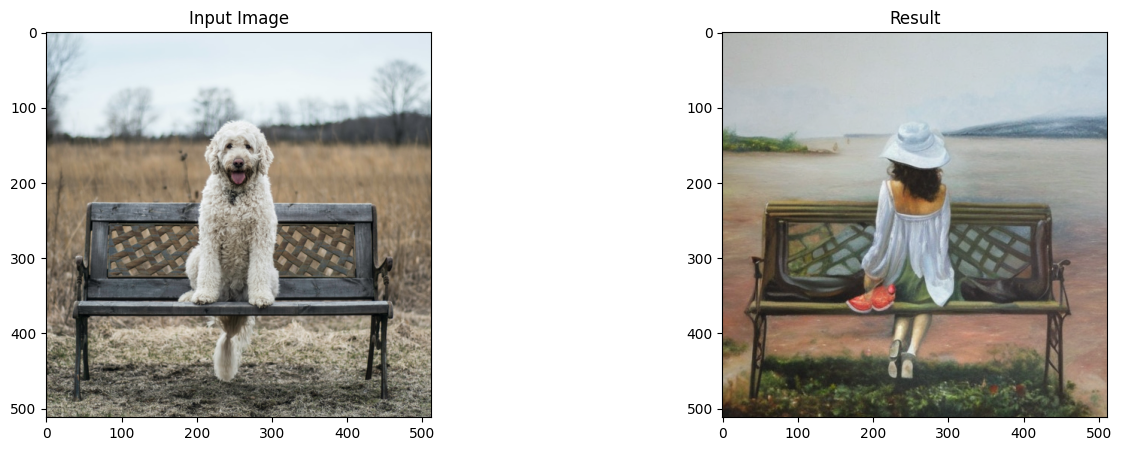

In [22]:
# Inpaint with a prompt for what we want the result to look like
prompt = "An oil painting of a women on a bench"
image = pipe(prompt=prompt, image=init_image).images[0]

# View the result
fig, axs = plt.subplots(1, 2, figsize=(16, 5))
axs[0].imshow(init_image);axs[0].set_title('Input Image')
axs[1].imshow(image);axs[1].set_title('Result');

이 결과가 img2img의 예와 어떻게 다른지 확인해보기 바란다. 여기서는 훨씬 더 많은 색상 변형이 있지만 전체 구조는 여전히 원본에 충실한 것을 알 수 있다. 그러나, 여자에 주목하면, 개 모양과 일치하도록 매우 이상한 해부학적 구조가 주어졌기 때문에 이 예시에서는 부적합한 사람을 생성했다고 볼 수 있겠으나, 어떤 경우에는 매우 유용할지도 모른다.